![](figs/se04.png)
# Workshop Instructions
***
- <img src="figs/icons/write.svg" width="20" style="filter: invert(41%) sepia(96%) saturate(1449%) hue-rotate(210deg) brightness(100%) contrast(92%);"/> Follow along by typing the code yourself - this helps with learning!
- <img src="figs/icons/code.svg" width="20" style="filter: invert(100%) sepia(100%) saturate(2000%) hue-rotate(40deg) brightness(915%) contrast(100%);"/> Code cells marked as "Exercise" are for you to complete
- <img src="figs/icons/reminder.svg" width="20" style="filter: invert(100%) sepia(1500%) saturate(1500%) hue-rotate(30deg) brightness(450%) contrast(70%);"/> Look for hints if you get stuck
- <img src="figs/icons/success.svg" width="20" style="filter: invert(56%) sepia(71%) saturate(5293%) hue-rotate(117deg) brightness(95%) contrast(101%);"/> Compare your solution with the provided answers
- <img src="figs/icons/list.svg" width="20" style="filter: invert(19%) sepia(75%) saturate(6158%) hue-rotate(312deg) brightness(87%) contrast(116%);"/> Don't worry if you make mistakes - debugging is part of learning!

In [1]:
from pathlib import Path
import sys

helper_utils = Path.cwd() / "utils"
sys.path.append(str(helper_utils))

import utils 
import shutil
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

checker = utils.core.ExerciseChecker("SE04")
quizzer = utils.core.QuizManager("SE04")

Faculty of Science and Engineering 🔬
The University of Manchester 
Invoking utils version: 0.9.0


# 1. Convolutional Neural Networks (CNNs)
***
> <img src="figs/icons/write.svg" width="20" style="filter: invert(41%) sepia(96%) saturate(1449%) hue-rotate(210deg) brightness(100%) contrast(92%);"/> **Definition**: Convolutional Neural Networks (CNNs) are a specialized type of neural network designed for processing structured grid-like data, such as images, by using mathematical operations called convolutions.

CNNs have revolutionized computer vision tasks and are the foundation of many modern systems for image recognition, object detection, segmentation, and more. Their architecture is inspired by the organization of the visual cortex in animals, where individual neurons respond to stimuli in restricted regions called receptive fields.

## 1.1 Why Standard Neural Networks Struggle with Images
***
Images present unique challenges that make standard fully-connected neural networks inefficient:

| Challenge | Description |
|-----------|-------------|
| **Spatial Relationships** | Standard networks don't account for spatial relationships between pixels |
| **Parameter Explosion** | A 224×224×3 image would require over 150,000 weights per neuron |
| **Translation Invariance** | Objects can appear anywhere in an image but have the same meaning |
| **Feature Hierarchy** | Images contain low-level features (edges, textures) that compose into higher-level features |
***

<figure style="background-color: white; border-radius: 10px; padding: 20px; text-align: center; margin: 0 auto;">
    <img src="figs/image_rgb.png" alt="Image multi-dimensionality" align="center" style="width: 60%; height: auto; margin: 0 auto;">
</figure>

CNNs address these challenges through specialized architecture components that we'll explore in this workshop.

Let's begin by understanding the core operation that gives CNNs their name: convolution.

# 2. The Convolution Operation
***
> <img src="figs/icons/write.svg" width="20" style="filter: invert(41%) sepia(96%) saturate(1449%) hue-rotate(210deg) brightness(100%) contrast(92%);"/> **Definition**: A convolution in the context of CNNs is a mathematical operation that combines two functions by multiplying them and integrating over their overlapping regions.

In simple terms, convolution involves sliding a small window (called a filter or kernel) over an image and performing an element-wise multiplication between the filter and the pixel values, then summing the results to produce a single output value for each position.

## 2.1 How Convolution Works
***

| Step | Description |
|------|-------------|
| 1 | Position the filter at the top-left corner of the image |
| 2 | Perform element-wise multiplication between the filter and the corresponding image pixels |
| 3 | Sum all the resulting values to get a single output value |
| 4 | Move the filter to the next position (typically one pixel to the right) |
| 5 | Repeat steps 2-4 until the entire image has been covered |
***

<figure style="background-color: white; border-radius: 10px; padding: 20px; text-align: center; margin: 0 auto;">
    <img src="figs/convolution_hyperparameters.gif" alt="CNN Structure" align="center" style="width: 50%; height: auto; margin: 0 auto;">
</figure>

This process creates what's called a feature map, which highlights specific patterns or features in the image that match the filter pattern.

> <img src="figs/icons/reminder.svg" width="20" style="filter: invert(100%) sepia(1500%) saturate(1500%) hue-rotate(30deg) brightness(450%) contrast(70%);"/> **Note**: In deep learning libraries, what's actually implemented is technically cross-correlation rather than convolution (the filter is not flipped). However, since the filters are learned during training, this distinction doesn't matter in practice.

Let's first load an example image to work with:

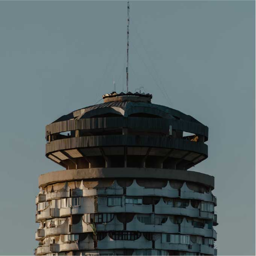

In [2]:
asc_image = Path.cwd() / "figs" / "ascent.jpg"
asc_image = Image.open(asc_image).resize((256, 256))
asc_image

## 2.2 Key Parameters in Convolution
***
The convolution operation is governed by several key parameters that affect the output dimensions and characteristics of the feature map. PyTorch provides a convenient way to implement convolutional layers using the `torch.nn.Conv2d` class. The key parameters include:

| Parameter | Description | Effect on Output Dimensions |
|-----------|-------------|---------------------------|
| **Kernel Size** | The dimensions of the filter (e.g., 3×3, 5×5) | Larger kernels reduce output size more |
| **Stride** | How many pixels the filter shifts at each step | Larger strides reduce output dimensions |
| **Padding** | Adding extra pixels around the border | Can preserve input dimensions |
| **Dilation** | Spacing between kernel elements | Increases receptive field without increasing parameters |

Understanding how these parameters affect the output dimensions is crucial for designing effective CNN architectures. The formula for calculating the output dimensions of a convolutional layer is:

$$\text{Output Size} = \left\lfloor\frac{\text{Input Size} - \text{Kernel Size} + 2 \times \text{Padding}}{\text{Stride}} + 1\right\rfloor$$

where $\lfloor \cdot \rfloor$ represents the floor operation (rounding down to the nearest integer).

> <img src="figs/icons/reminder.svg" width="20" style="filter: invert(100%) sepia(1500%) saturate(1500%) hue-rotate(30deg) brightness(450%) contrast(70%);"/> **Note**: This formula assumes that both the input and kernel are square, but it can be applied separately to height and width for rectangular inputs and kernels.

Let's implement a function to calculate the output size of a convolutional layer for various parameter combinations.

In [3]:
# Exercise 1: Calculating Convolutional Output Dimensions 🎯
# Implement a function to calculate the output dimensions after applying convolution
# with different kernel sizes, strides, and padding values.

def calculate_output_size(input_height:int, input_width:int, 
                          kernel_size:int, stride:int=1, padding:int=0) -> tuple:
    """Calculate the output dimensions after applying convolution.
    
    Args:
        input_height (int): Height of the input feature map
        input_width (int): Width of the input feature map
        kernel_size (int): Size of the square kernel
        stride (int, optional): Convolution stride. Defaults to 1.
        padding (int, optional): Padding size. Defaults to 0.
        
    Returns:
        tuple: (output_height, output_width)
    """
    # Your code here: Implement the formula for calculating output dimensions
    output_height = int((input_height - kernel_size + 2 * padding) / stride + 1) # Your code here
    output_width = int((input_width - kernel_size + 2 * padding) / stride + 1) # Your code here
    
    return output_height, output_width

# Test the function with different parameters
# Case 1: Standard convolution with a 3x3 kernel, stride=1, no padding
input1 = (28, 28)  # e.g., MNIST image size
output1 = calculate_output_size(input1[0], input1[1], kernel_size=3) # Your code here

# Case 2: Convolution with padding=1 to preserve dimensions
input2 = (224, 224)  # e.g., Standard ImageNet size
output2 = calculate_output_size(input2[0], input2[1], kernel_size=3, stride=1, padding=1) # Your code here

# Case 3: Convolution with stride=2 for downsampling
input3 = (128, 128)
output3 = calculate_output_size(input3[0], input3[1], kernel_size=5, stride=2, padding=2) # Your code here

# Case 4: Custom parameters
input4 = (64, 64)
output4 = calculate_output_size(input4[0], input4[1], kernel_size=7, stride=2, padding=3) # Your code here

print(f"Case 1: {input1} → {output1} (3x3 kernel, stride=1, no padding)")
print(f"Case 2: {input2} → {output2} (3x3 kernel, stride=1, padding=1)")
print(f"Case 3: {input3} → {output3} (5x5 kernel, stride=2, padding=2)")
print(f"Case 4: {input4} → {output4} (7x7 kernel, stride=2, padding=3)")

# ✅ Check your answer
answer = {
    'output1': output1,
    'output2': output2,
    'output3': output3,
    'output4': output4
}
checker.check_exercise(1, answer)

Case 1: (28, 28) → (26, 26) (3x3 kernel, stride=1, no padding)
Case 2: (224, 224) → (224, 224) (3x3 kernel, stride=1, padding=1)
Case 3: (128, 128) → (64, 64) (5x5 kernel, stride=2, padding=2)
Case 4: (64, 64) → (32, 32) (7x7 kernel, stride=2, padding=3)
--------------------------------------------------------------------------------
❌ Error checking output1: unsupported operand type(s) for -: 'tuple' and 'int'
💡 Hint: Remember the formula for output size: ((W - K + 2P) / S) + 1
❌ Error checking output2: unsupported operand type(s) for -: 'tuple' and 'int'
❌ Error checking output3: unsupported operand type(s) for -: 'tuple' and 'int'
❌ Error checking output4: unsupported operand type(s) for -: 'tuple' and 'int'


## 2.3 What is a Filter?
***
> <img src="figs/icons/write.svg" width="20" style="filter: invert(41%) sepia(96%) saturate(1449%) hue-rotate(210deg) brightness(100%) contrast(92%);"/> **Definition**: A filter (or kernel) is a small matrix used in convolutional operations to extract features from an image. It slides over the image, performing element-wise multiplication and summing the results to produce a single output value.

Filters allow CNNs to learn and detect specific patterns, such as edges, textures, and shapes, by adjusting their weights during training. The concept of filters is central to computer vision tasks, and there are existing filters for common tasks, such as edge detection and blurring. Let's explore some of these filters and their effects on images.

We are going to try the following filters:

| Filter | Kernel | Description |
|--------|--------|-------------|
| **Edge Detection** | $$\begin{bmatrix} 1 & 0 & -1 \\ 1 & 0 & -1 \\ 1 & 0 & -1 \end{bmatrix}$$ | Detects vertical edges |
| **Sharpening** | $$\begin{bmatrix} 0 & -1 & 0 \\ -1 & 5 & -1 \\ 0 & -1 & 0 \end{bmatrix}$$ | Enhances edges and details |
| **Embossing** | $$\begin{bmatrix} -2 & -1 & 0 \\ -1 & 1 & 1 \\ 0 & 1 & 2 \end{bmatrix}$$ | Creates a 3D effect |

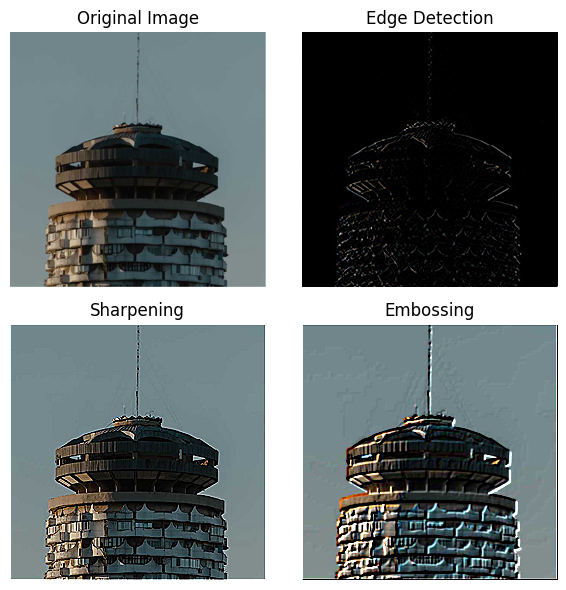

--------------------------------------------------------------------------------
❌ Missing filter_horizontal_edges
💡 Hint: Horizontal edge detection filters should have negative values in the top row and positive in the bottom row
❌ Missing filter_vertical_edges
❌ Missing output_check


In [4]:
# Exercise 2: Designing Convolutional Filters with PyTorch 🎯
# In this exercise, you will implement common filters used in image processing using PyTorch

def apply_filter_pytorch(image, kernel):
    """Apply a convolutional filter to an image using PyTorch.
    
    Args:
        image (numpy.ndarray): Input image (grayscale or RGB)
        kernel (numpy.ndarray): Convolutional kernel/filter
        
    Returns:
        numpy.ndarray: Filtered image
    """
    # Make a copy of the image to avoid modifying the original
    image_copy = image.copy().astype(np.float32)
    
    # For RGB: rearrange to PyTorch format (B, C, H, W)
    image_tensor = torch.from_numpy(image_copy).permute(2, 0, 1).unsqueeze(0) # Your code here
    channels = image_copy.shape[2] # Your code here
    
    # Convert kernel to PyTorch tensor
    kernel_tensor = torch.from_numpy(kernel.astype(np.float32)).unsqueeze(0).unsqueeze(0) # Your code here
    
    # Create a convolutional layer with our kernel as weights
    # Use groups=channels to apply the same kernel to each channel independently
    conv_layer = torch.nn.Conv2d(in_channels=channels, 
                                 out_channels=channels,
                                 kernel_size=kernel.shape[0],
                                 bias=False,
                                 padding=kernel.shape[0]//2, 
                                 groups=channels)
    
    # Set the weights to our kernel
    with torch.no_grad():
        for i in range(channels):
            conv_layer.weight.data[i] = kernel_tensor
    
    # Apply convolution
    with torch.no_grad():
        filtered = conv_layer(image_tensor) # Your code here
    
    # Convert back to numpy array in correct format
    filtered_image = filtered.squeeze(0).permute(1, 2, 0).numpy() # Your code here
    
    # Clip values to be in valid range for images (0-255)
    filtered_image = np.clip(filtered_image, 0, 255).astype(np.uint8) # Your code here
    return filtered_image

# Design several common convolutional filters

# 1. Edge detection filter (should highlight boundaries between different regions)
edge_detection_kernel = np.array([
    [1, 0, -1],
    [0, 0, 0],
    [-1, 0, 1]
])

# 2. Sharpening filter (should enhance details by increasing contrast)
sharpen_kernel = np.array([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
])

# 3. Embossing filter (should give a 3D effect by highlighting edges with shadows)
emboss_kernel = np.array([
    [-2, -1, 0],
    [-1, 1, 1],
    [0, 1, 2]
])

# Load a test image - use the ascent image we loaded earlier
test_image = np.array(asc_image)

# Apply the filters to the test image using PyTorch
edge_detect_image = apply_filter_pytorch(test_image, edge_detection_kernel)
sharpened_image = apply_filter_pytorch(test_image, sharpen_kernel)
embossed_image = apply_filter_pytorch(test_image, emboss_kernel)

# Display the results
fig, axes = plt.subplots(2, 2, figsize=(6, 6))

axes[0, 0].imshow(test_image)
axes[0, 0].set_title("Original Image")
axes[0, 0].axis('off')

axes[0, 1].imshow(edge_detect_image)
axes[0, 1].set_title("Edge Detection")
axes[0, 1].axis('off')

axes[1, 0].imshow(sharpened_image)
axes[1, 0].set_title("Sharpening")
axes[1, 0].axis('off')

axes[1, 1].imshow(embossed_image)
axes[1, 1].set_title("Embossing")
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

# ✅ Check your answer
answer = {
    'apply_filter': apply_filter_pytorch,
    'edge_detection_kernel': edge_detection_kernel,
    'sharpen_kernel': sharpen_kernel,
    'emboss_kernel': emboss_kernel
}
checker.check_exercise(2, answer)

Above we used predefined filters, but in practice, the filters are learned during training. The network learns to adjust the filter weights to detect relevant features for the specific task at hand.

Let's see how the output of a simple convolution operation looks like. 

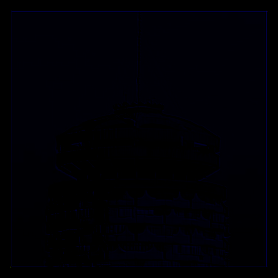

In [5]:
conv2d = torch.nn.Conv2d(
    in_channels=3, 
    out_channels=3, 
    kernel_size=3, 
    stride=1, 
    padding=12, 
)

# Change the shape of the image to (C, H, W)
torch_asc = torch.from_numpy(np.array(asc_image)).permute(2,0,1)
torch_asc = torch_asc.unsqueeze(0).float() # Add batch dimension

conv2d.eval()
filtered_asc = conv2d(torch_asc)
# Reverse the transformation to get back to (H, W, C)
filtered_asc = filtered_asc.squeeze(0).detach().numpy().transpose(1, 2, 0)

# Make sure the values are in the range [0, 255]
# and convert to uint8 for PIL
filtered_asc = np.clip(filtered_asc, 0, 255).astype(np.uint8) 
filtered_asc_img = Image.fromarray(filtered_asc)
filtered_asc_img

# 3. Preparing image data
***
Since images can be seen as 3D tensors, we need to convert them into a format suitable for processing. In PyTorch, images are typically represented as 4D tensors with the shape `(batch_size, channels, height, width)`. For a single image, the shape would be `(1, 3, height, width)`.

To prepare the image data, we will use the `torchvision` library, which provides convenient functions for loading and transforming images. 

## 3.1 Torchvision transforms
***
Python uses `PIL` (Python Imaging Library) to handle images, and while `PIL` is great for basic image manipulation, it can be slow for large datasets. To speed up the process, we can use `torchvision.transforms`, which provides a set of common image transformations that can be applied to images in a more efficient way.

| Transform | PyTorch Function | Description |
|-----------|------------------|-------------|
| **Resize** | `transforms.Resize(size)` | Resizes the image to the specified size |
| **CenterCrop** | `transforms.CenterCrop(size)` | Crops the image at the center to the specified size |
| **RandomCrop** | `transforms.RandomCrop(size)` | Crops the image randomly to the specified size |
| **RandomHorizontalFlip** | `transforms.RandomHorizontalFlip(p)` | Flips the image horizontally with probability `p` |
| **RandomRotation** | `transforms.RandomRotation(degrees)` | Rotates the image randomly within the specified degrees |
| **Normalize** | `transforms.Normalize(mean, std)` | Normalizes the image tensor with the specified mean and standard deviation |
| **ColorJitter** | `transforms.ColorJitter(brightness, contrast, saturation, hue)` | Randomly changes the brightness, contrast, saturation, and hue of the image |
| **ToTensor** | `transforms.ToTensor()` | Converts the image to a PyTorch tensor |

These transformations can be combined to create a preprocessing pipeline that prepares the images for training. The `transforms.Compose` function allows us to chain multiple transformations together.

> <img src="figs/icons/reminder.svg" width="20" style="filter: invert(100%) sepia(1500%) saturate(1500%) hue-rotate(30deg) brightness(450%) contrast(70%);"/> **Notes**:
> - Resizing is important because CNNs require fixed-size inputs.
> - The `ToTensor` transformation converts the image to a PyTorch tensor, and it also scales the pixel values to the range [0, 1]. 
> - Normalization is a common practice in deep learning to ensure that the input data has a mean of 0 and a standard deviation of 1. This helps the model converge faster during training.
***

> <img src="figs/icons/code.svg" width="20" style="filter: invert(100%) sepia(100%) saturate(2000%) hue-rotate(40deg) brightness(915%) contrast(100%);"/> **Snippet 1**: Composing transformations
```python
from torchvision import transforms

ts = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])
```


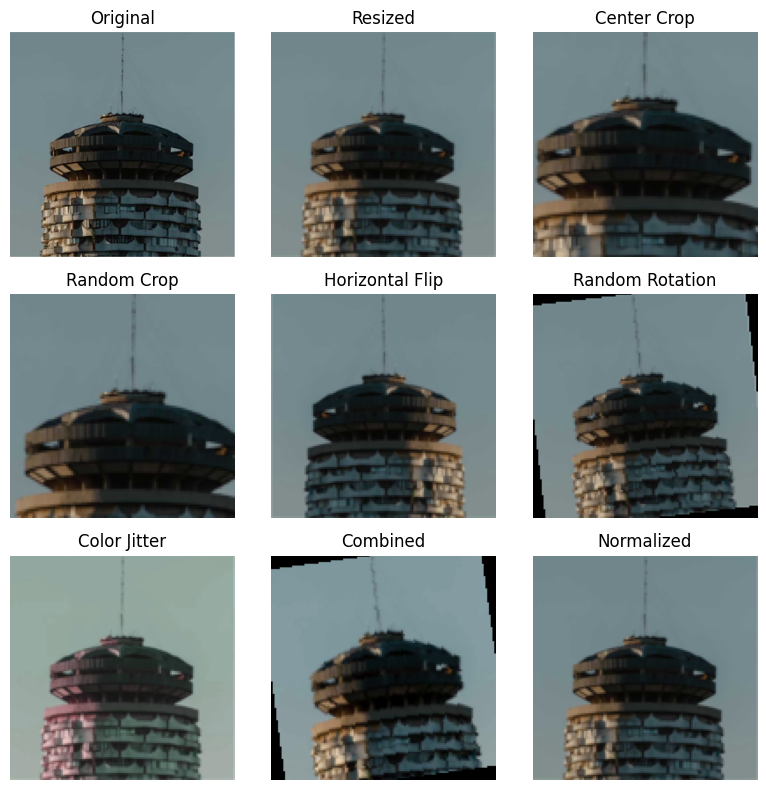

--------------------------------------------------------------------------------
✅ transformations is correct!
❌ Error checking visualization: argument of type 'bool' is not iterable
💡 Hint: Make sure to implement all required transformations using torchvision.transforms


In [6]:
# Exercise 3: Implementing Image Transformations 🎯
# In this exercise, you will implement and visualize various image transformations
# commonly used in computer vision tasks

from torchvision import transforms

def apply_transformations(image_path):
    """Apply and visualize various image transformations.
    
    Args:
        image_path (str or Path): Path to the input image
        
    Returns:
        dict: Dictionary of transformed images
    """
    # Load the image
    img = Image.open(image_path) if isinstance(image_path, (str, Path)) else image_path
    
    # Define transformations
    # 1. Basic resize and center crop
    resize_transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor()
    ])
    
    # 2. Center crop transformation
    center_crop_transform = transforms.Compose([
        transforms.Resize(150),  # Resize the smaller edge to 150 pixels
        transforms.CenterCrop(100),  # Crop a 100x100 square from the center
        transforms.ToTensor()
    ])
    
    # 3. Random crop transformation
    random_crop_transform = transforms.Compose([
        transforms.Resize(150),
        transforms.RandomCrop(100),  # Your code here: random crop of size 100x100
        transforms.ToTensor()
    ])
    
    # 4. Random horizontal flip transformation
    hflip_transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(p=1.0),  # Your code here: 100% flip probability
        transforms.ToTensor()
    ])
    
    # 5. Random rotation transformation
    rotate_transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.RandomRotation(degrees=30),  # Your code here: random rotation
        transforms.ToTensor()
    ])
    
    # 6. Color jitter transformation
    color_transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.3),  # Your code here
        transforms.ToTensor()
    ])
    
    # 7. Combined transformations (practical data augmentation)
    combined_transform = transforms.Compose([
        transforms.Resize(150),
        transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor()
    ])
    
    # 8. Normalization transformation
    norm_transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Your code here: ImageNet norms
    ])
    
    # Apply transformations
    transforms_dict = {
        'Original': transforms.ToTensor()(img),
        'Resized': resize_transform(img),
        'Center Crop': center_crop_transform(img),
        'Random Crop': random_crop_transform(img),
        'Horizontal Flip': hflip_transform(img),
        'Random Rotation': rotate_transform(img),
        'Color Jitter': color_transform(img),
        'Combined': combined_transform(img),
        'Normalized': norm_transform(img)
    }
    
    return transforms_dict

# Function to visualize transformed images
def visualize_transformations(transformed_images):
    """Visualize the transformed images.
    
    Args:
        transformed_images (dict): Dictionary of transformed images
    """
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    axes = axes.flatten()
    
    for i, (title, img_tensor) in enumerate(transformed_images.items()):
        if title == 'Normalized':
            # Denormalize for visualization
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            img_tensor = img_tensor * std + mean
            
        img_numpy = img_tensor.permute(1, 2, 0).numpy()
        img_numpy = np.clip(img_numpy, 0, 1)
        
        axes[i].imshow(img_numpy)
        axes[i].set_title(title)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Apply transformations to an image and visualize the results
# Use the ascent image we loaded earlier as a test image
transforms_dict = apply_transformations(asc_image)
visualize_transformations(transforms_dict)

# Let's also test on a crack image from our dataset
# crack_img_path = list(crack_folder.glob("*.jpg"))[0]
# transforms_dict_crack = apply_transformations(crack_img_path)
# visualize_transformations(transforms_dict_crack)

# ✅ Check your answer
answer = {
    'transformations': {
        'resize_implemented': 'Resized' in transforms_dict,
        'crop_implemented': 'Center Crop' in transforms_dict and 'Random Crop' in transforms_dict,
        'flip_implemented': 'Horizontal Flip' in transforms_dict,
        'rotation_implemented': 'Random Rotation' in transforms_dict,
        'color_jitter_implemented': 'Color Jitter' in transforms_dict,
        'normalization_implemented': 'Normalized' in transforms_dict
    },
    'visualization': True
}
checker.check_exercise(3, answer)

## 3.2 Historical Crack Dataset
***
In this session, we are going to be working with the *Historical-crack18-19* dataset. The dataset contains annotated images for non-invasive surface crack detection in historical buildings. The goal is to train a model that can accurately identify cracks in these images. The current manual visual inspection of built environments is time-consuming, labor-intensive, prone to errors, costly, and lacks scalability. Therefore, the dataset is designed to facilitate the development of deep learning models for automatic crack detection.

The dataset contains:

| Attribute | Number of Images | 
| ----------|------------------|
| **Crack** | 757 |
| **No crack** | 3,139 |

As we can see, the dataset is highly imbalanced, with a significant number of images without cracks. This imbalance can affect the performance of the model, as it may learn to predict the majority class (no crack) more often than the minority class (crack). In a first instance, we are going to take a subset of the dataset to balance the classes. 

In [7]:
data_path = Path.cwd() / "datasets"
dataset_path = utils.data.download_dataset("historical cracks",
                                   dest_path=data_path,
                                   extract=True,
                                   remove_compressed=True)

Downloading:
Historical-crack18-19: A dataset of annotated images for non-invasive surface crack detection in historical buildings
> Authors: Esraa Elhariri, Nashwa El-Bendary, Shereen Taie
> Year: 2020
> Website: https://www.sciencedirect.com/science/article/pii/S2352340922000774#fig0001



Extracting Historical Building Cracks.zip: 100%|██████████| 3899/3899 [00:01<00:00, 2345.08it/s]


In [8]:
main_data_path = list(dataset_path.glob("*"))[0]
img_crack = main_data_path / "crack"
img_no_crack = main_data_path / "non-crack"

# Create a new folder for the balanced dataset
balanced_data_path = main_data_path / "balanced"
balanced_data_path.mkdir(parents=True, exist_ok=True)

# Create train, test, and validation folders
train_folder = balanced_data_path / "train"
train_folder.mkdir(parents=True, exist_ok=True)
test_folder = balanced_data_path / "test"
test_folder.mkdir(parents=True, exist_ok=True)
val_folder = balanced_data_path / "val"
val_folder.mkdir(parents=True, exist_ok=True)

for folder in [train_folder, test_folder, val_folder]:
    (folder / "crack").mkdir(parents=True, exist_ok=True)
    (folder / "no_crack").mkdir(parents=True, exist_ok=True)

crack_images = list(img_crack.glob("*.jpg"))
no_crack_images = random.sample(list(img_no_crack.glob("*.jpg")), len(crack_images))

# Shuffle the images
random.shuffle(crack_images)
random.shuffle(no_crack_images)

# Split the images into train, test, and validation sets
train_ix = int(0.8 * len(crack_images))
val_ix = int(0.9 * len(crack_images))
test_ix = len(crack_images)

train_crack_images = crack_images[:train_ix]
val_crack_images = crack_images[train_ix:val_ix]
test_crack_images = crack_images[val_ix:test_ix]

train_no_crack_images = no_crack_images[:train_ix]
val_no_crack_images = no_crack_images[train_ix:val_ix]
test_no_crack_images = no_crack_images[val_ix:test_ix]

# Copy the images to the new folders
for img in train_crack_images:
    shutil.copy(img, train_folder / "crack")
for img in train_no_crack_images:
    shutil.copy(img, train_folder / "no_crack")
for img in val_crack_images:
    shutil.copy(img, val_folder / "crack")
for img in val_no_crack_images:
    shutil.copy(img, val_folder / "no_crack")
for img in test_crack_images:
    shutil.copy(img, test_folder / "crack")
for img in test_no_crack_images:
    shutil.copy(img, test_folder / "no_crack")

Images size: (256, 256)


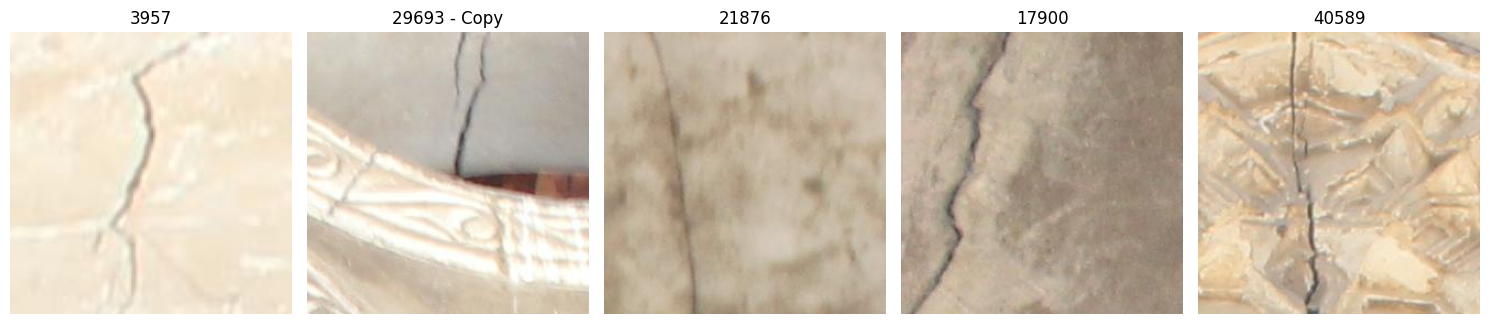

In [9]:
# Randomly select 5 images
random_images = random.sample(crack_images, 5)

# Display the images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for ax, img_path in zip(axes, random_images):
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(img_path.stem)
plt.tight_layout()

print (f"Images size: {img.size}")

## 3.3 PyTorch ImageFolder
***
While we can load images using `PIL`, PyTorch provides a more efficient way to handle large datasets through the `torchvision.datasets` module. This module contains the `ImageFolder` class, which allows us to load images from a directory structure where each subdirectory represents a class. The `ImageFolder` class automatically assigns labels based on the subdirectory names.

The `ImageFolder` class requires a root directory containing subdirectories for each class. The directory structure should look like this:

```bash
dataset/
    ├── class-1/
    │   ├── image1.jpg
    │   ├── image2.jpg
    │   └── ...
    └── class-2/
        ├── image1.jpg
        ├── image2.jpg
        └── ...
```

The function automatically assigns labels to the images based on the subdirectory names. Moreover, it can also apply transformations to the images using the `transform` parameter.

The key parameters of the `ImageFolder` class are:
| Parameter | Description |
|-----------|-------------|
| **root** | The root directory containing the dataset |
| **transform** | A function/transform to apply to the images |
| **target_transform** | A function/transform to apply to the target (label) |
| **loader** | A function to load the images (default is `PIL.Image.open`) |
| **is_valid_file** | A function to check if a file is valid (default is `None`) |
***
> <img src="figs/icons/code.svg" width="20" style="filter: invert(100%) sepia(100%) saturate(2000%) hue-rotate(40deg) brightness(915%) contrast(100%);"/> **Snippet 2**: Using ImageFolder
```python
from torchvision.datasets import ImageFolder

dataset = ImageFolder(root='path/to/dataset', transform=ts)
# Accessing the first image and its label
image, label = dataset[0]
print(f"Image shape: {image.shape}, Label: {label}")
```

In [10]:
# Exercise 4: Data Augmentation and Loading with PyTorch 🎯
# Implment:
# 1. Data augmentation techniques
# 2. Data loading with ImageFolder

from torch.utils.data import random_split, DataLoader
from torchvision.datasets import ImageFolder

ts_train = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

ts_test_val = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

train_data = ImageFolder(root=train_folder, transform=ts_train)
test_data = ImageFolder(root=test_folder, transform=ts_test_val)
val_data = ImageFolder(root=val_folder, transform=ts_test_val)

train_data.classes

['crack', 'no_crack']

## 3.4 PyTorch DataLoaders
***
As we discussed in the previous session, when training a model we need to load the data in batches. PyTorch provides the `DataLoader` class to handle this efficiently. The `DataLoader` class takes a dataset and provides an iterable over the dataset, allowing us to load data in batches.

The model expects our image data to be formatted as a 4D tensor with the shape `(batch_size, channels, height, width)`.

<figure style="background-color: white; border-radius: 10px; padding: 20px; text-align: center; margin: 0 auto;">
    <img src="figs/image_batches.png" alt="DataLoader" align="center" style="width: 50%; height: auto; margin: 0 auto;">
</figure>

The `DataLoader` class provides several key parameters to customize the data loading process:
| Parameter | Description |
|-----------|-------------|
| **dataset** | The dataset to load data from (e.g., `ImageFolder`) |
| **batch_size** | The number of samples per batch |
| **shuffle** | Whether to shuffle the data at every epoch |
| **num_workers** | The number of subprocesses to use for data loading |
| **pin_memory** | Whether to pin memory for faster data transfer to GPU |
| **drop_last** | Whether to drop the last incomplete batch |
***
> <img src="figs/icons/code.svg" width="20" style="filter: invert(100%) sepia(100%) saturate(2000%) hue-rotate(40deg) brightness(915%) contrast(100%);"/> **Snippet 3**: Creating a DataLoader
```python
from torch.utils.data import DataLoader

# Create a DataLoader for the dataset
train_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
# Iterate through the DataLoader
for images, labels in train_loader:
    print(f"Batch shape: {images.shape}, Labels: {labels}")
    break  # Just to show the first batch
```

In [11]:
# Exercise 5: DataLoader 🎯
train_dl = DataLoader(train_data, batch_size=32, shuffle=True)
test_dl = DataLoader(test_data, batch_size=32, shuffle=False)
val_dl = DataLoader(val_data, batch_size=32, shuffle=False)

# 4. Implementing CNNs
***
The architecture of a CNN is not that different from a standard neural network. The main difference is that CNNs use convolutional layers instead of fully connected layers. This means that after each convolutional layer, we typically apply a non-linear activation function (like ReLU). 

The output of the CNN is then passed through one or more fully connected layers to produce the final output. Thus, we need to keep track of the output size after each layer to ensure that the dimensions match up correctly.

A diagram of a conventional CNN architecture is shown below.

<figure style="background-color: white; border-radius: 10px; padding: 20px; text-align: center; margin: 0 auto;">
    <img src="figs/cnn.png" alt="CNN Architecture" align="center" style="width: 70%; height: auto; margin: 0 auto;">
</figure>

We are going to implement a simple CNN architecture for the crack detection task. The architecture consists of the following layers:

| Type | Layer | Input Size | Output Size | Activation Function |
|-------|-------|------------|-------------|---------------------|
| Convolution | `Conv2d` | `(3, 64, 64)` | `(16, 64, 64)` | ReLU |
| Fully Connected | `Linear` | `(16 * 64 * 64)` | `16` | ReLU |
| Fully Connected | `Linear` | `16` | `2` | None |


In [12]:
# Exercise 6: Implementing a Simple CNN Model 🎯
class simpleCNN(torch.nn.Module):
    def __init__(self, n_classes):
        super(simpleCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3,  16, kernel_size=3, stride=1, padding=1)
        self.fc1 = torch.nn.Linear(16 * 64 * 64, 16)
        self.fc2 = torch.nn.Linear(16, n_classes)

    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))
        x = x.view(-1, 16 * 64 * 64)  # Flatten the tensor
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model_v1 = simpleCNN(len(train_data.classes))
criterion = torch.nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model_v1.parameters(), lr=2e-3)
num_epochs = 20

simpleCNN Training:   0%|          | 0/20 [00:00<?, ?it/s]

Training Batch 0/38:   0%|          | 0/38 [00:00<?, ?it/s]

Validation Batch 0/5:   0%|          | 0/5 [00:00<?, ?it/s]

Training Batch 0/38:   0%|          | 0/38 [00:00<?, ?it/s]

Validation Batch 0/5:   0%|          | 0/5 [00:00<?, ?it/s]

Training Batch 0/38:   0%|          | 0/38 [00:00<?, ?it/s]

Validation Batch 0/5:   0%|          | 0/5 [00:00<?, ?it/s]

Training Batch 0/38:   0%|          | 0/38 [00:00<?, ?it/s]

Validation Batch 0/5:   0%|          | 0/5 [00:00<?, ?it/s]

Training Batch 0/38:   0%|          | 0/38 [00:00<?, ?it/s]

Validation Batch 0/5:   0%|          | 0/5 [00:00<?, ?it/s]

Training Batch 0/38:   0%|          | 0/38 [00:00<?, ?it/s]

Validation Batch 0/5:   0%|          | 0/5 [00:00<?, ?it/s]

Training Batch 0/38:   0%|          | 0/38 [00:00<?, ?it/s]

Validation Batch 0/5:   0%|          | 0/5 [00:00<?, ?it/s]

Training Batch 0/38:   0%|          | 0/38 [00:00<?, ?it/s]

Validation Batch 0/5:   0%|          | 0/5 [00:00<?, ?it/s]

Training Batch 0/38:   0%|          | 0/38 [00:00<?, ?it/s]

Validation Batch 0/5:   0%|          | 0/5 [00:00<?, ?it/s]

Training Batch 0/38:   0%|          | 0/38 [00:00<?, ?it/s]

Validation Batch 0/5:   0%|          | 0/5 [00:00<?, ?it/s]

Training Batch 0/38:   0%|          | 0/38 [00:00<?, ?it/s]

Validation Batch 0/5:   0%|          | 0/5 [00:00<?, ?it/s]

Training Batch 0/38:   0%|          | 0/38 [00:00<?, ?it/s]

Validation Batch 0/5:   0%|          | 0/5 [00:00<?, ?it/s]

Training Batch 0/38:   0%|          | 0/38 [00:00<?, ?it/s]

Validation Batch 0/5:   0%|          | 0/5 [00:00<?, ?it/s]

Training Batch 0/38:   0%|          | 0/38 [00:00<?, ?it/s]

Validation Batch 0/5:   0%|          | 0/5 [00:00<?, ?it/s]

Training Batch 0/38:   0%|          | 0/38 [00:00<?, ?it/s]

Validation Batch 0/5:   0%|          | 0/5 [00:00<?, ?it/s]

Training Batch 0/38:   0%|          | 0/38 [00:00<?, ?it/s]

Validation Batch 0/5:   0%|          | 0/5 [00:00<?, ?it/s]

Training Batch 0/38:   0%|          | 0/38 [00:00<?, ?it/s]

Validation Batch 0/5:   0%|          | 0/5 [00:00<?, ?it/s]

Training Batch 0/38:   0%|          | 0/38 [00:00<?, ?it/s]

Validation Batch 0/5:   0%|          | 0/5 [00:00<?, ?it/s]

Training Batch 0/38:   0%|          | 0/38 [00:00<?, ?it/s]

Validation Batch 0/5:   0%|          | 0/5 [00:00<?, ?it/s]

Training Batch 0/38:   0%|          | 0/38 [00:00<?, ?it/s]

Validation Batch 0/5:   0%|          | 0/5 [00:00<?, ?it/s]

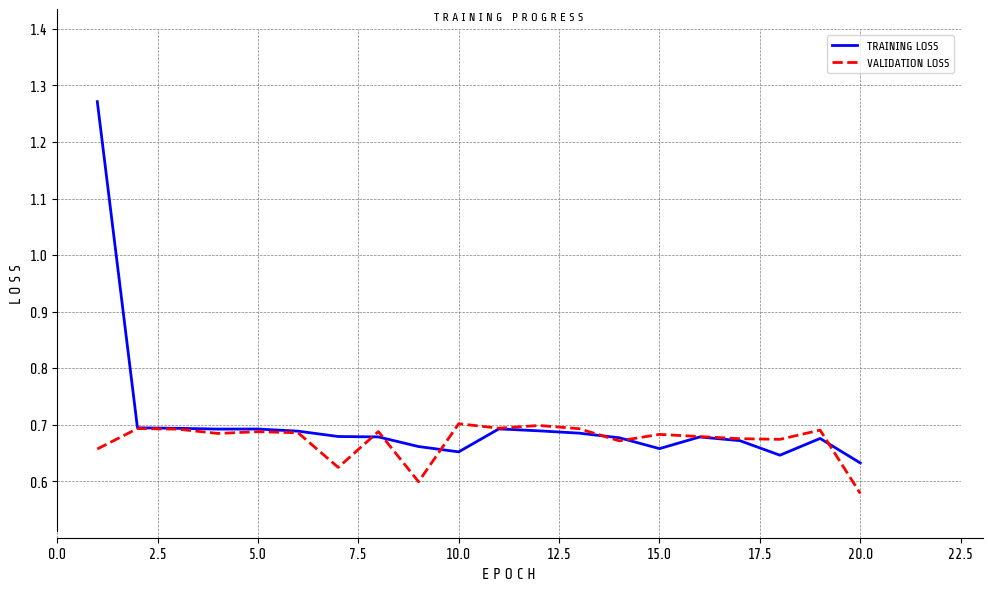

In [13]:
model_v1 = utils.ml.train_model(model_v1,
                             criterion,
                             optimiser,
                             train_loader=train_dl,
                             val_loader=val_dl,
                             num_epochs=num_epochs,
                             plot_loss=True)

## 4.1 Getting predictions
***
The output of the last layer gives us the predicted class probabilities for the two classes: crack and no crack. Therefore, in order for us to get the predicted class, we need to apply a softmax function to the output of the last layer. However, PyTorch `CrossEntropyLoss` combines the softmax and the negative log-likelihood loss in a single function, so we don't need to apply softmax explicitly. The `CrossEntropyLoss` function expects the raw logits (the output of the last layer) as input, and it will apply softmax internally.

To predict the class, we can use the `torch.argmax` function to get the index of the maximum value in the output tensor. This index corresponds to the predicted class.

> <img src="figs/icons/code.svg" width="20" style="filter: invert(100%) sepia(100%) saturate(2000%) hue-rotate(40deg) brightness(915%) contrast(100%);"/> **Snippet 4**: Obtaining the predicted class
```python
model_v1.eval()

with torch.no_grad():
    for images, labels in test_dl:
        outputs = model_v1(images.to(device))
        print(outputs[:-1])
        _, predicted = torch.max(outputs, dim=1)
        print(predicted)
        break
```

In [ ]:
# Exercise 7: Evaluating the Model 🎯
acc = utils.ml.compute_accuracy(model_v1, test_dl)
print(f"Test accuracy: {acc*100:.2f}%")

cls_report = utils.ml.compute_classification_report(model_v1, test_dl, class_names=train_data.classes)
print('-' * 60)
print(f"Classification Report:\n{cls_report}")

Test accuracy: 78.29%
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

       crack       0.74      0.88      0.80        76
    no_crack       0.85      0.68      0.76        76

    accuracy                           0.78       152
   macro avg       0.79      0.78      0.78       152
weighted avg       0.79      0.78      0.78       152



## 4.2 Recreating CNN architectures
***
There are many different CNN architectures that have been proposed in the literature, each with its own strengths and weaknesses. Some of the most popular architectures include:

| Architecture | Description | Key Features |
|--------------|-------------|--------------|
| **LeNet** | One of the first CNN architectures, designed for handwritten digit recognition | 5 layers, small kernel sizes |
| **AlexNet** | A deeper architecture that won the ImageNet competition in 2012 | 8 layers, ReLU activation, dropout, data augmentation |
| **VGG** | A very deep architecture with small kernel sizes | 16-19 layers, uniform architecture, small kernels |
| **ResNet** | Introduced residual connections to allow for very deep networks | 50-152 layers, skip connections, batch normalization |
| **Inception** | Introduced the inception module for multi-scale feature extraction | 22-164 layers, parallel convolutions, pooling layers |
| **DenseNet** | Introduced dense connections between layers | 121-201 layers, dense connections, feature reuse |

These architectures have been shown to perform well on a variety of tasks, and they can be used as a starting point for building custom CNNs. Furthermore, many of these architectures are often visualised as a series of blocks, where each block consists of a convolutional layer followed by an activation function and a pooling layer. We are going to implement a mini version of the VGG architecture, which looks like this:

<figure style="background-color: white; border-radius: 10px; padding: 20px; text-align: center; margin: 0 auto;">
    <img src="figs/vgg.png" alt="VGG Architecture" align="center" style="width: 70%; height: auto; margin: 0 auto;">
</figure>

## 4.3 Pooling
***
> img src="figs/icons/write.svg" width="20" style="filter: invert(41%) sepia(96%) saturate(1449%) hue-rotate(210deg) brightness(100%) contrast(92%);"/> **Definition**: Pooling is a downsampling operation used in CNNs to reduce the spatial dimensions of feature maps while retaining important information. 

Pooling helps to reduce the number of parameters and computations in the network, making it more efficient and less prone to overfitting. There are several types of pooling operations, but the most common ones are:

| Pooling Type | PyTorch Function | Description |
|--------------|------------------|-------------|
| **Max Pooling** | `torch.nn.MaxPool2d(kernel_size, stride)` | Takes the maximum value in each region defined by the kernel size |
| **Average Pooling** | `torch.nn.AvgPool2d(kernel_size, stride)` | Takes the average value in each region defined by the kernel size |
| **Global Average Pooling** | `torch.nn.AdaptiveAvgPool2d(output_size)` | Reduces each feature map to a single value by averaging over the entire map |
| **Global Max Pooling** | `torch.nn.AdaptiveMaxPool2d(output_size)` | Reduces each feature map to a single value by taking the maximum over the entire map |

The pooling operation can be visualised like this:

<figure style="background-color: white; border-radius: 10px; padding: 20px; text-align: center; margin: 0 auto;">
    <img src="figs/pooling.png" alt="Pooling Operation" align="center" style="width: 50%; height: auto; margin: 0 auto;">
</figure>

Most commonly, we use max pooling, as it helps to retain the most important features while discarding less relevant information. The pooling operation is typically applied after a convolutional layer and an activation function. 

## 4.4 Regularisation
***
As briefly mentioned in the previous session, regularisation is a technique used to prevent overfitting in machine learning models. Overfitting occurs when a model learns the training data too well, including noise and outliers, leading to poor generalisation on unseen data. In CNNs, regularisation techniques are crucial due to the large number of parameters and the complexity of the models. Some common regularisation techniques used in CNNs include:
| Regularisation Technique | Pytorch Function | Description |
|--------------------------|------------------|-------------|
| **Dropout** | `torch.nn.Dropout(p)` | Randomly sets a fraction of input units to 0 at each update during training time, which helps prevent overfitting |
| **L2 Regularisation** | `torch.nn.functional.mse_loss()` | Adds a penalty on the size of the weights to the loss function. This is also known as weight decay |
| **Batch Normalisation** | `torch.nn.BatchNorm2d(num_features)` | Normalises the output of a previous activation layer by subtracting the batch mean and dividing by the batch standard deviation. This helps to stabilise the learning process and can lead to faster convergence |
| **Data Augmentation** | `torchvision.transforms` | Increases the diversity of the training set by applying random transformations to the input data, such as rotation, translation, and scaling. This helps to improve the generalisation of the model |
| **Early Stopping** | `torch.nn.utils` | Stops training when the validation loss stops improving, preventing overfitting |
| **Weight Decay** | `torch.optim.AdamW` | Adds a penalty on the size of the weights to the loss function, similar to L2 regularisation. This is also known as weight decay |

For our tiny VGG architecture, we are going to use dropout and batch normalisation. The dropout layer is applied after the activation function of the fully connected layers, while the batch normalisation layer is applied after the convolutional layers.

In [ ]:
# Exercise 8: Implementing a More Complex CNN Model 🎯
class tinyVGG(torch.nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        
        # Add pooling layers
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.flat = torch.nn.Flatten()
        # Adjust input size for fully connected layer due to pooling
        self.fc1 = torch.nn.Linear(64 * 8 * 8, 128)  # Size reduced by factor of 8 due to 3 pooling layers
        self.fc2 = torch.nn.Linear(128, n_classes)
        
        # dropout for regularization
        self.dropout1 = torch.nn.Dropout(p=0.05)
        self.dropout2 = torch.nn.Dropout(p=0.1)
        
        # batch normalization for more stable training
        self.batch_norm1 = torch.nn.BatchNorm2d(16, momentum=0.8)
        self.batch_norm2 = torch.nn.BatchNorm2d(32, momentum=0.8)
        self.batch_norm3 = torch.nn.BatchNorm2d(64, momentum=0.8)

    def forward(self, x):
        x = self.dropout1(torch.nn.functional.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool(x)
        x = self.dropout1(torch.nn.functional.relu(self.batch_norm2(self.conv2(x))))
        x = self.pool(x)
        x = self.dropout1(torch.nn.functional.relu(self.batch_norm3(self.conv3(x))))
        x = self.pool(x)
        x = self.flat(x)
        x = self.dropout2(torch.nn.functional.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


In [ ]:
model_v2 = tinyVGG(len(train_data.classes))
criterion_reg = torch.nn.CrossEntropyLoss()
optimiser_reg = torch.optim.Adam(model_v2.parameters(),
                                 lr=1e-3,
                                 betas=(0.9, 0.999),
                                #  weight_decay=1e-5,  # L2 regularization (weight decay)
                                 ) 
num_epochs_reg = 45
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimiser_reg,
    mode='min',
    factor=0.1,
    patience=2,
)

In [ ]:
model_v2 = utils.ml.train_model(model_v2,
                  criterion_reg,
                  optimiser_reg,
                  train_loader=train_dl,
                  val_loader=val_dl,
                  num_epochs=num_epochs_reg,
                  early_stopping=True,
                  patience=5,
                  tolerance=1e-2,
                  save_path= Path.cwd() / "my_models" / "model_v2.pt",
                  plot_loss=True)

In [ ]:
# Load the best model
model_v2.load_state_dict(torch.load(Path.cwd() / "my_models" / "model_v2.pt"))

In [ ]:
# Exercise 9: Evaluating the tiny VGG🎯
acc = utils.ml.compute_accuracy(model_v2, test_dl)
print(f"Test accuracy: {acc*100:.2f}%")

cls_report = utils.ml.compute_classification_report(model_v2, test_dl, class_names=train_data.classes)
print('-' * 60)
print(f"Classification Report:\n{cls_report}")